In [71]:
import pandas as pd
import numpy as np
import joblib
from pathlib import Path
import shap

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error

sns.set_theme(style='whitegrid')

In [72]:
# 1. Load your scraped dataset
df = pd.read_csv('../collect data/data/sri_lankan_vehicles.csv')
df.head()

,Title,Price,Mileage,Location,Date,URL,DetailURL,AdTitle,PostedBy,PostedOn,...,YOM,MileageKM,Gear,FuelType,Options,EngineCC,Details,ContactDigits,Views,ViewsRaw
0,Toyota PREMIO G SUPERIOR 2013 Car,Negotiable,146000 (km),Horana,2026-02-17,https://riyasewana.com/buy/toyota-premio-g-sal...,https://riyasewana.com/buy/toyota-premio-g-sal...,Toyota PREMIO G SUPERIOR 2013 Car (Used),Vidarshani,2026-02-17,...,2013,146000,Automatic,Petrol,"AIR CONDITION, POWER STEERING, POWER MIRROR, P...",1500,YOM - 2013\nYOR - 2014\nPush start\nElectric s...,777747959,1353,1353 Views
1,Toyota Prius ZVW30 2012 Car,"Rs. 9,800,000",210000 (km),Kottawa,2026-01-31,https://riyasewana.com/buy/toyota-prius-zvw30-...,https://riyasewana.com/buy/toyota-prius-zvw30-...,Toyota Prius ZVW30 2012 Car (Used),Piumal,2026-01-31,...,2012,210000,Automatic,Hybrid,"AIR CONDITION, POWER STEERING, POWER MIRROR, P...",1800,2012 Toyota Prius ZVW30 – Solar Roof / Moonroo...,705157246,4602,4602 Views
2,Suzuki Wagon R Custom Hybrid ZX 2024 Car,"Rs. 8,300,000",3300 (km),Colombo,2026-02-17,https://riyasewana.com/buy/suzuki-wagon-r-sale...,https://riyasewana.com/buy/suzuki-wagon-r-sale...,Suzuki Wagon R Custom Hybrid ZX 2024 Car Unreg...,Wickramasinghe,2026-02-17,...,2024,3300,Automatic,Hybrid,"AIR CONDITION, POWER STEERING, POWER MIRROR, P...",660,2024 Suzuki Wagon R custom hybrid ZX 3300 Km\n...,716988889,743,743 Views
3,Daihatsu Mira ES Limited 2025 Car,"Rs. 6,675,000",1120 (km),Piliyandala,2026-02-18,https://riyasewana.com/buy/daihatsu-mira-es-sa...,https://riyasewana.com/buy/daihatsu-mira-es-sa...,Daihatsu Mira ES Limited 2025 Car Brand New,Sandaruwan,2026-02-18,...,2025,1120,Automatic,Petrol,-,650,DAIHATSU MIRA E.S SAFETY\nBRAND NEW 2025\n• 20...,777302074,854,854 Views
4,Toyota TOYOTA AQUA URBAN 2015 Car,Negotiable,168000 (km),Negombo,2026-02-20,https://riyasewana.com/buy/toyota-toyota-aqua-...,https://riyasewana.com/buy/toyota-toyota-aqua-...,Toyota TOYOTA AQUA URBAN 2015 Car (Used),Viran,2026-02-20,...,2015,168000,Automatic,Hybrid,"AIR CONDITION, POWER STEERING, POWER MIRROR, P...",1500,TOYOTA AQUA URBAN\nYOM 2015\nYOR 2017\nBATTER...,764389219,2,2 Views


In [73]:
# 2. Clean the Price column (Remove 'Rs.', commas, and spaces)
df['Price_Clean'] = df['Price'].astype(str).str.replace('Rs.', '', regex=False).str.replace(',', '').str.strip()
df['Price_Clean'] = pd.to_numeric(df['Price_Clean'], errors='coerce')

# 3. Ensure Mileage is numeric
df['MileageKM_Clean'] = pd.to_numeric(df['MileageKM'], errors='coerce')

# 4. Feature Engineering from the seller description
details_lower = df['Details'].astype(str).str.lower()
df['is_first_owner'] = details_lower.str.contains('1st owner|first owner').astype(int)
df['is_accident_free'] = details_lower.str.contains('accident free|no accident|100% accident').astype(int)
df['is_mint_condition'] = details_lower.str.contains('mint condition|superb condition|excellent condition|showroom condition').astype(int)
df['has_service_records'] = details_lower.str.contains('service records|maintenance records|records available').astype(int)

# 5. Select only the columns used by the model
ml_columns = [
    'Make', 'Model', 'YOM', 'MileageKM_Clean', 'Gear', 'FuelType', 'EngineCC',
    'is_first_owner', 'is_accident_free', 'is_mint_condition', 'has_service_records',
    'Price_Clean',
]

df_ml_ready = df[ml_columns].dropna(subset=['Price_Clean']).copy()
df_ml_ready['YOM'] = pd.to_numeric(df_ml_ready['YOM'], errors='coerce')
df_ml_ready['EngineCC'] = pd.to_numeric(df_ml_ready['EngineCC'], errors='coerce')

data_dir = Path('../data')
data_dir.mkdir(parents=True, exist_ok=True)
df_ml_ready.to_csv(data_dir / 'ml_ready_vehicles.csv', index=False)

print(f'Rows after initial cleaning: {len(df_ml_ready)}')
df_ml_ready.head()

Rows after initial cleaning: 162


,Make,Model,YOM,MileageKM_Clean,Gear,FuelType,EngineCC,is_first_owner,is_accident_free,is_mint_condition,has_service_records,Price_Clean
1,Toyota,Prius ZVW30,2012,210000.0,Automatic,Hybrid,1800.0,0,0,1,1,9800000.0
2,Suzuki,Wagon R Custom Hybrid ZX,2024,3300.0,Automatic,Hybrid,660.0,0,0,0,0,8300000.0
3,Daihatsu,Mira ES Limited,2025,1120.0,Automatic,Petrol,650.0,0,0,0,0,6675000.0
6,Toyota,Vitz 130,2017,41000.0,Automatic,Petrol,1000.0,0,0,0,0,8075000.0
7,Toyota,ALLION 260 G PLUS,2010,135000.0,Automatic,Petrol,1500.0,0,1,0,1,8750000.0


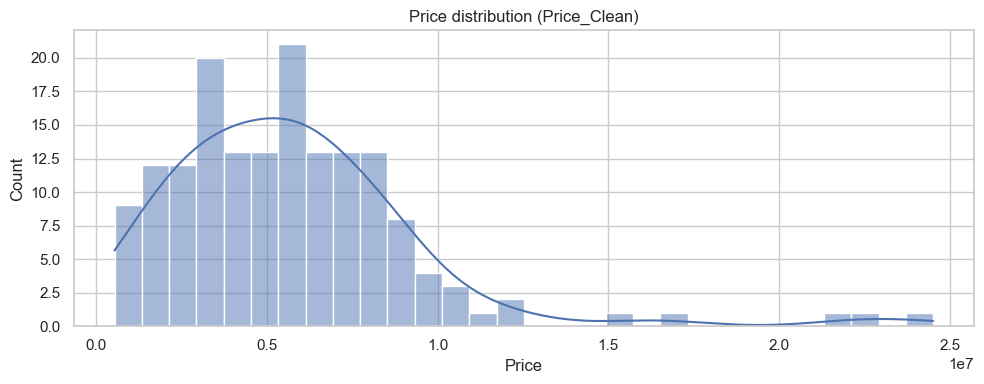

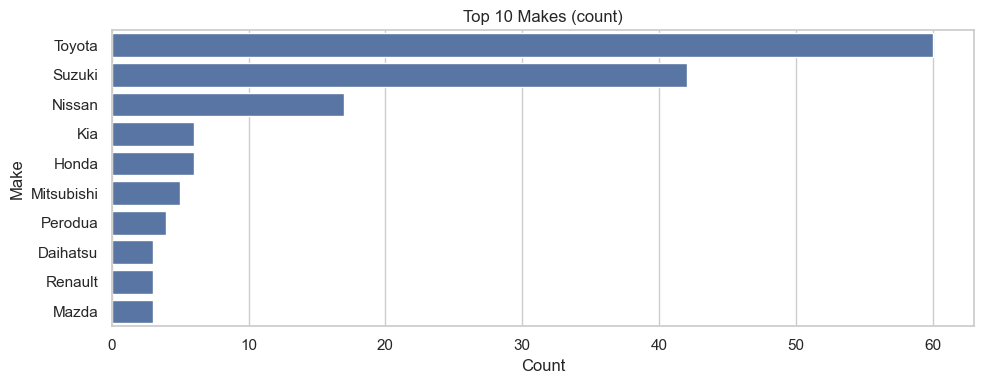

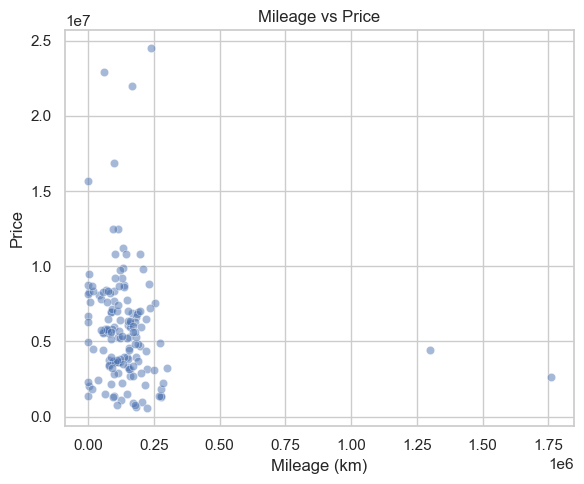

In [74]:
# EDA: quick tables + plots (after initial cleaning)

# Table 1: missing values in ML columns
missing_table = (
    df_ml_ready.isna()
    .sum()
    .sort_values(ascending=False)
    .to_frame('missing_count')
 )
missing_table['missing_pct'] = (missing_table['missing_count'] / len(df_ml_ready) * 100).round(2)
missing_table

# Table 2: summary stats for numeric columns
df_ml_ready[['Price_Clean', 'MileageKM_Clean', 'YOM', 'EngineCC']].describe().T

# Plot 1: distribution of target price
plt.figure(figsize=(10, 4))
sns.histplot(df_ml_ready['Price_Clean'].dropna(), bins=30, kde=True)
plt.title('Price distribution (Price_Clean)')
plt.xlabel('Price')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Plot 2: top makes count
top_makes = df_ml_ready['Make'].value_counts().head(10)
plt.figure(figsize=(10, 4))
sns.barplot(x=top_makes.values, y=top_makes.index)
plt.title('Top 10 Makes (count)')
plt.xlabel('Count')
plt.ylabel('Make')
plt.tight_layout()
plt.show()

# Plot 3: mileage vs price (scatter)
plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_ml_ready, x='MileageKM_Clean', y='Price_Clean', alpha=0.5)
plt.title('Mileage vs Price')
plt.xlabel('Mileage (km)')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

In [75]:
# 6. Handle Outliers using IQR (Interquartile Range)
def remove_outliers(data: pd.DataFrame, col: str) -> pd.DataFrame:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

In [76]:
df_clean = remove_outliers(df_ml_ready, 'Price_Clean')
df_clean = remove_outliers(df_clean, 'MileageKM_Clean')
df_clean = df_clean.copy()
print(f'Dataset size after outlier removal: {len(df_clean)}')

Dataset size after outlier removal: 146


In [77]:
# 7. Preprocessing for XGBoost (train/test-safe)
target_col = 'Price_Clean'

X = df_clean.drop(columns=[target_col]).copy()
y = df_clean[target_col].copy()

categorical_features = ['Make', 'Model', 'Gear', 'FuelType']
numeric_features = [c for c in X.columns if c not in categorical_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent'))
        ,('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ],
    remainder='drop',
)

X_train_processed = preprocess.fit_transform(X_train)
X_test_processed = preprocess.transform(X_test)

# Save artifacts to the parent folder's model/ directory (../model)
model_dir = Path('../model')
model_dir.mkdir(parents=True, exist_ok=True)
joblib.dump(preprocess, model_dir / 'preprocess_ohe.pkl')

X_train_processed.shape, X_test_processed.shape

((116, 116), (30, 116))

In [78]:
# 8. Train an XGBoost model (baseline)
try:
    from xgboost import XGBRegressor
except ImportError as e:
    raise ImportError('xgboost is not installed. Install it with: pip install xgboost') from e

xgb_model = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
 )

xgb_model.fit(X_train_processed, y_train)
pred = xgb_model.predict(X_test_processed)
rmse = float(np.sqrt(mean_squared_error(y_test, pred)))
mae = float(mean_absolute_error(y_test, pred))

joblib.dump(xgb_model, model_dir / 'xgb_model.pkl')
{'rmse': rmse, 'mae': mae, 'train_rows': int(len(y_train)), 'test_rows': int(len(y_test))}

{'rmse': 1000300.7954678764,
 'mae': 767032.8125,
 'train_rows': 116,
 'test_rows': 30}

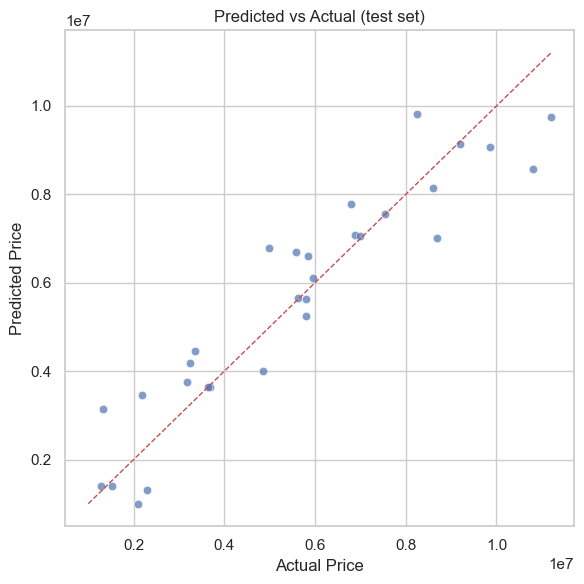

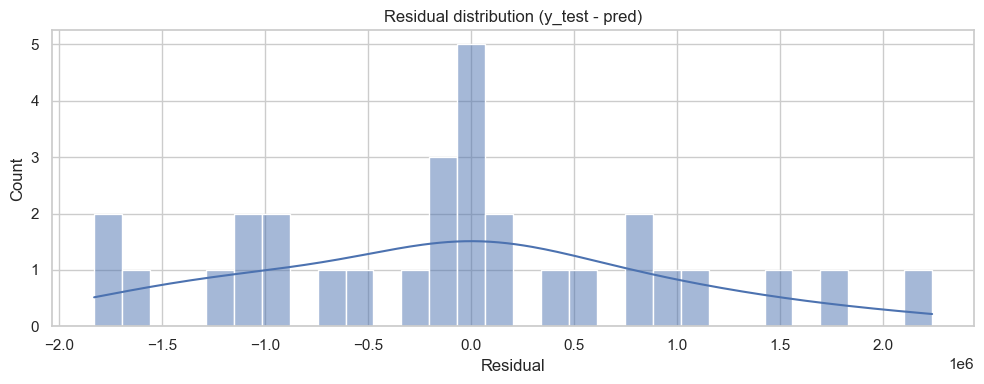

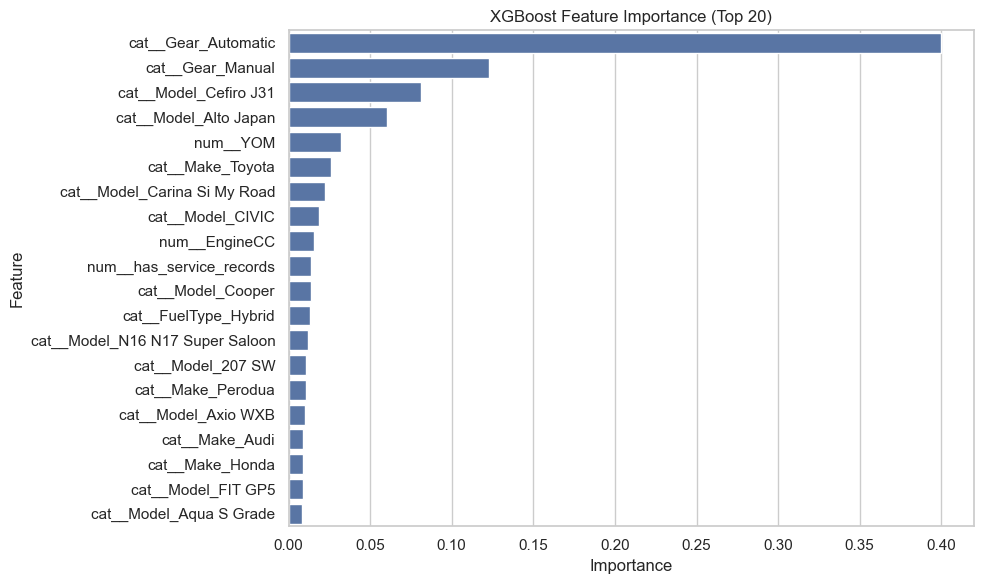

In [79]:
# Model diagnostics: plots (after training)

# Plot 4: predicted vs actual
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=pred, alpha=0.7)
min_v = float(min(y_test.min(), pred.min()))
max_v = float(max(y_test.max(), pred.max()))
plt.plot([min_v, max_v], [min_v, max_v], 'r--', linewidth=1)
plt.title('Predicted vs Actual (test set)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.tight_layout()
plt.show()

# Plot 5: residual distribution
residuals = (y_test.values - pred)
plt.figure(figsize=(10, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Residual distribution (y_test - pred)')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Plot 6: feature importance (top 20)
try:
    feature_names = preprocess.get_feature_names_out()
except Exception:
    feature_names = np.array([f'feature_{i}' for i in range(len(xgb_model.feature_importances_))])

importances = xgb_model.feature_importances_
fi = pd.DataFrame({'feature': feature_names, 'importance': importances})
fi = fi.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=fi, x='importance', y='feature')
plt.title('XGBoost Feature Importance (Top 20)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [80]:
# 1. Extract feature names from the ColumnTransformer pipeline
# Get numeric feature names
num_cols = numeric_features
# Get categorical feature names generated by the OneHotEncoder
cat_cols = preprocess.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
# Combine them in the exact order the ColumnTransformer outputs them
all_feature_names = list(num_cols) + list(cat_cols)

In [81]:
# 2. Initialize the SHAP TreeExplainer using your trained XGBoost model
explainer = shap.TreeExplainer(xgb_model)

Calculating SHAP values...


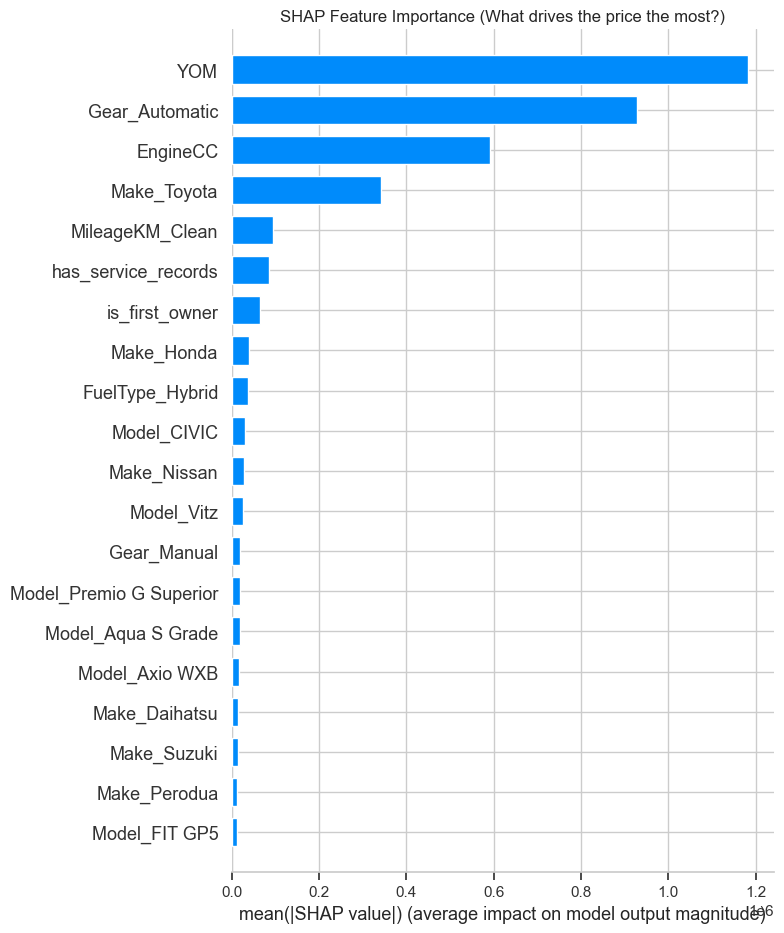

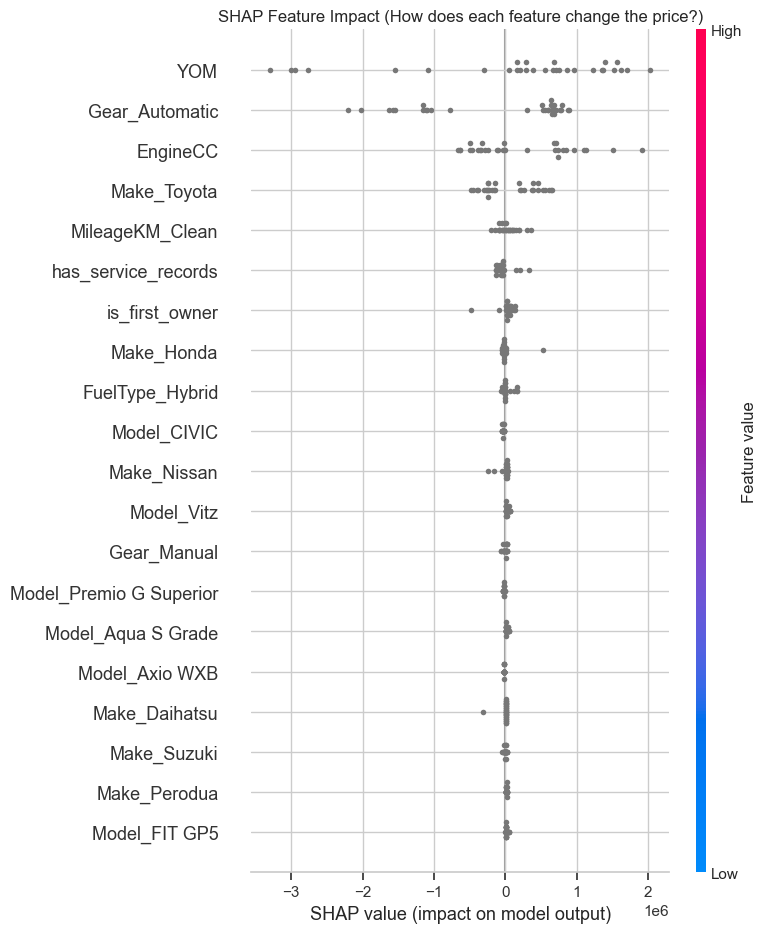

In [82]:
# 3. Calculate SHAP values for the transformed Test dataset
print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_test_processed)

# 4. Generate SHAP Bar Plot (Global Feature Importance)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_processed, feature_names=all_feature_names, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (What drives the price the most?)")
plt.tight_layout()
plt.show()

# 5. Generate SHAP Dot Plot (Directional Feature Impact)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_processed, feature_names=all_feature_names, show=False)
plt.title("SHAP Feature Impact (How does each feature change the price?)")
plt.tight_layout()
plt.show()